In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
EXPERIMENT_NAME = 'P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_DIR = '/data2/experiments/{}'.format(EXPERIMENT_NAME)

In [3]:
FEATURES_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_DEDUP_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)

features_3did_df = pd.read_pickle(FEATURES_3DID_DEDUP_FILE)
# features_3did_df['isotope_count'] = features_3did_df['envelope'].apply(lambda x: len(x))

In [4]:
features_3did_df.columns

Index(['monoisotopic_mz', 'charge', 'monoisotopic_mass', 'feature_intensity',
       'envelope_mono_peak_intensity', 'envelope', 'isotope_count',
       'deconvolution_score', 'precursor_id',
       'envelope_mono_peak_three_sigma_intensity', 'scan_apex', 'scan_lower',
       'scan_upper', 'rt_apex', 'rt_lower', 'rt_upper', 'feature_id'],
      dtype='object')

In [5]:
# load the PASEF de-duped features and constrain them to match the 3DID analysis parameters
FEATURES_DIR = '{}/features'.format(EXPERIMENT_DIR)
FEATURES_PASEF_DEDUP_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_DIR, EXPERIMENT_NAME, RUN_NAME)

features_pasef_df = pd.read_pickle(FEATURES_PASEF_DEDUP_FILE)

In [6]:
features_pasef_df.envelope = features_pasef_df.envelope.apply(lambda x: json.loads(x))

In [7]:
features_pasef_df['isotope_count'] = features_pasef_df.envelope.apply(lambda x: len(x))

In [8]:
features_pasef_df.columns

Index(['monoisotopic_mz', 'charge', 'intensity', 'intensity_full_rt_extent',
       'intensity_six_sigma', 'scan_apex', 'scan_lower', 'scan_upper',
       'rt_apex', 'rt_lower', 'rt_upper', 'precursor_id', 'envelope',
       'deconvolution_score', 'envelope_mono_peak_intensity', 'feature_id',
       'monoisotopic_mass', 'run_name', 'isotope_count'],
      dtype='object')

In [9]:
features_pasef_df = features_pasef_df[(features_pasef_df.deconvolution_score >= 100)]
features_3did_df = features_3did_df[(features_3did_df.deconvolution_score >= 100)]

In [10]:
print('there are {} features from 3DID, {} from PASEF'.format(len(features_3did_df), len(features_pasef_df)))

there are 88088 features from 3DID, 75096 from PASEF


In [22]:
features_pasef_df['intensity_log'] = np.log10(features_pasef_df.intensity)
features_pasef_df['method'] = 'pasef'
features_3did_df['intensity_log'] = np.log10(features_3did_df.feature_intensity)
features_3did_df['method'] = '3did'

In [23]:
intensities_l = [features_pasef_df,features_3did_df]
intensities_df = pd.concat(intensities_l, sort=False)

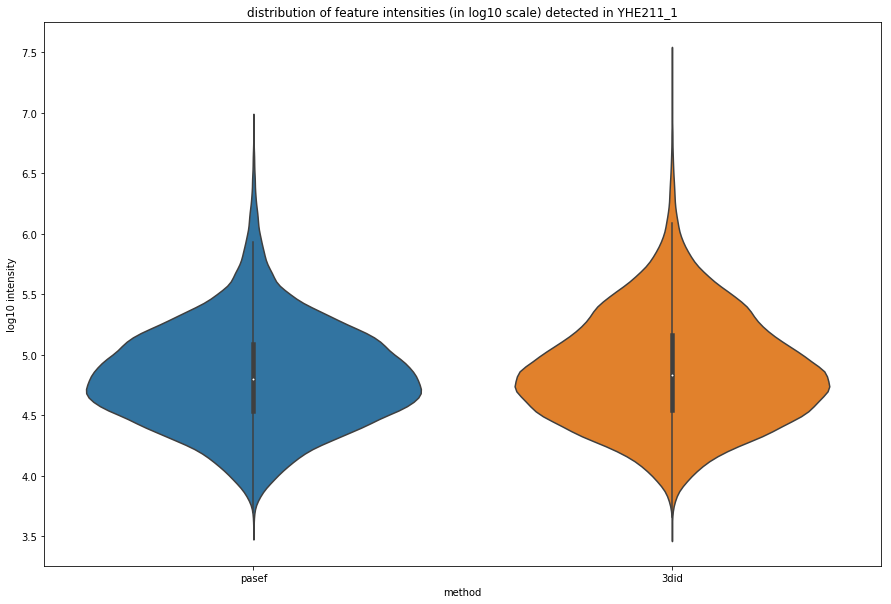

In [24]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=intensities_df.method, y=intensities_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')

#### compare charge states

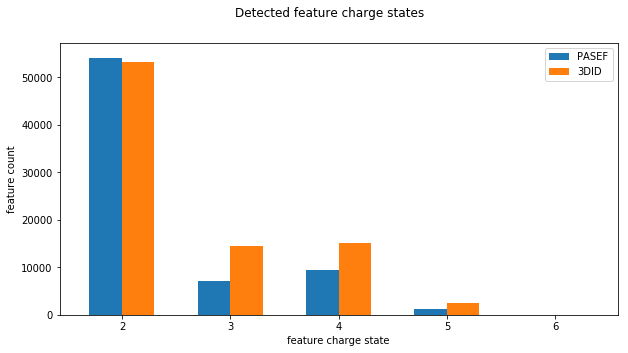

In [14]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(10)
plt.hist([features_pasef_df.charge, features_3did_df.charge], bins=np.arange(start=2, stop=8)-0.5, rwidth=0.6, label=['PASEF','3DID'])
plt.legend(loc='best')
plt.xlabel('feature charge state')
plt.ylabel('feature count')
plt.margins(0.06)
plt.suptitle('Detected feature charge states')
# plt.title('{}'.format(feature_list_filename))
plt.show()

#### compare isotope counts

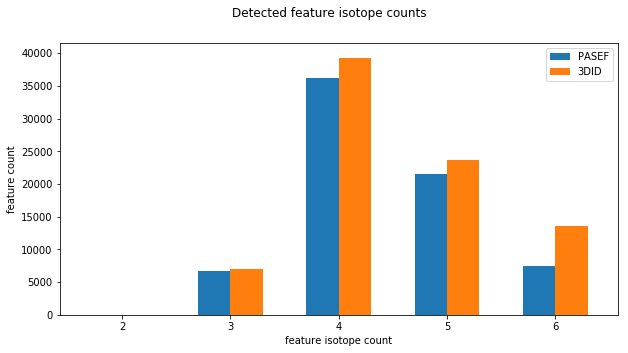

In [17]:
f, ax1 = plt.subplots()
f.set_figheight(5)
f.set_figwidth(10)
plt.hist([features_pasef_df.isotope_count, features_3did_df.isotope_count], bins=np.arange(start=2, stop=8)-0.5, rwidth=0.6, label=['PASEF','3DID'])
plt.legend(loc='best')
plt.xlabel('feature isotope count')
plt.ylabel('feature count')
plt.margins(0.06)
plt.suptitle('Detected feature isotope counts')
# plt.title('{}'.format(feature_list_filename))
plt.show()

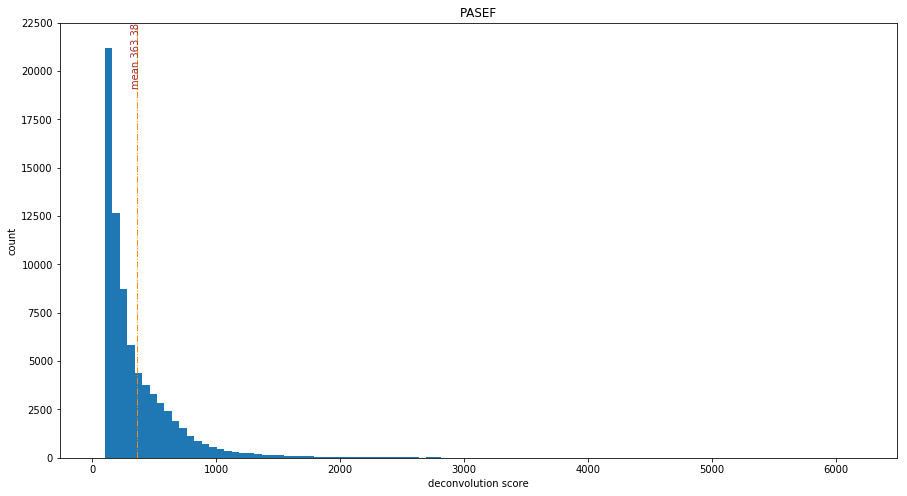

In [18]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
values = features_pasef_df.deconvolution_score
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('deconvolution score')
plt.ylabel('count')
plt.title('PASEF')
# plt.xlim((0,2))
# plt.ylim((0,1000))

plt.show()

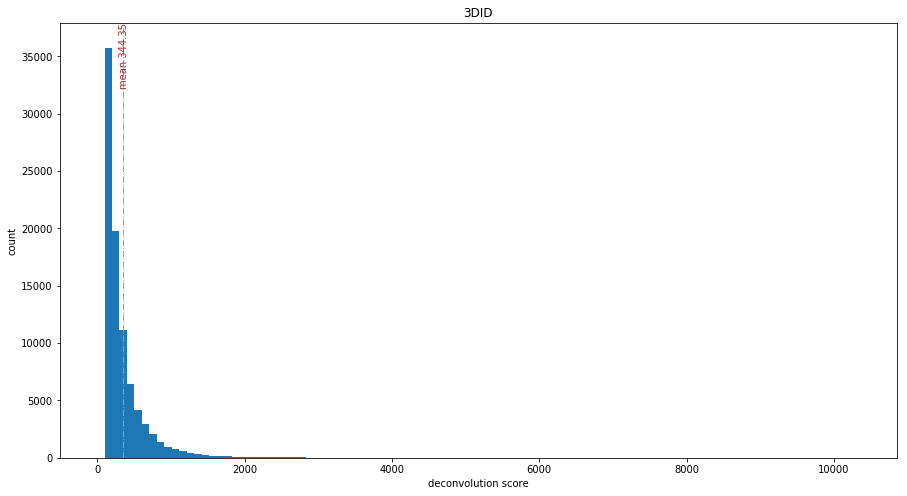

In [20]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 100
values = features_3did_df.deconvolution_score
y, x, _ = ax1.hist(values, bins=bins)
mean = np.mean(values)
ax1.axvline(mean, color='darkorange', lw=1.0, ls='-.', label='mean')
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax1.text(mean*0.85, y.max()*0.98, "mean {}".format(round(mean,2)), **text_style, rotation='vertical')

plt.xlabel('deconvolution score')
plt.ylabel('count')
plt.title('3DID')
# plt.xlim((0,2))
# plt.ylim((0,1000))

plt.show()